#### ДЗ_30 - классифкация текста по эмоциональной окраске c использованием BERT
#### Татур А.А.
##### 13.03.2023
##### v.0.1

##### Задача: используя сет с набором твитов построить классификатор по эмоциональной окраске с использованием BERT.

In [27]:
import numpy as np
import pandas as pd
import os

import re
import emoji
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
STOPWORDS  = stopwords.words('english') + ['im']

from sklearn.preprocessing import LabelEncoder

import gc

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

import matplotlib.pyplot as plt

In [2]:
#### Функция для построения графика обучения на тренировочном и обучающем наборе:
def test_val_graph (history,train,val):
    plt.plot(history.history[train], label='Точность на обучающем наборе')
    plt.plot(history.history[val], label='Точность на проверочном наборе')
    plt.xlabel('Цикл обучения')
    plt.ylabel('Точность')
    plt.legend()
    plt.show()
    pass;

In [3]:
#### Функция для очистки текста и лемматизации

def cleaner(tweet):
    tweet = tweet.lower() # приводим к нижнему регистру
    tweet = tweet.replace("<unk>", "") #убираем значение <unk>, которое встречается в некоторых строках
    tweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", tweet) #убираем ссылки
    tweet = re.sub(r'[^\w\s]', '', tweet) #убираем знаки препинания
    tweet = ''.join (c for c in tweet if c not in string.digits)  #убираем все символы, которые относятся к цифрам
    tweet = ' '.join(c for c in tweet.split() if emoji.is_emoji(c)==False\
                     and c not in string.punctuation\
                     and c not in STOPWORDS) #убираем эмодзи, знаки пунктуации и стоп-слова
    tweet = tweet.replace("#", "").replace("_", " ").replace("pm","") #убираем решетки, н ижние подчеркивания и обозначния времени
    
    lemmatizer = WordNetLemmatizer() #лемматизируем слова
    one_lemma = [lemmatizer.lemmatize(word) for word in tweet]
    tweet=''.join(one_lemma)
    
    return tweet

#### 01. Загружаем тренировочный и тестовый датасет

In [4]:
df_training = pd.read_csv('twitter_training.csv',
                          header=None, 
                          usecols={2,3},
                          names=['Sentiment', 'Tweet'])

df_test = pd.read_csv('twitter_validation.csv',
                            header=None, 
                            usecols={2,3},
                            names=['Sentiment', 'Tweet'])

df_training['Tweet']=df_training['Tweet'].astype(str)
df_test['Tweet']=df_test['Tweet'].astype(str)

#### 02. Проводим очистку датасетов

In [61]:
df_training['cleaned'] = df_training['Tweet'].map(lambda x: cleaner(x))
df_test['cleaned'] = df_test['Tweet'].map(lambda x: cleaner(x))

#### 03. Кодируем категориальные признаки

In [62]:
labeles = LabelEncoder()
train_labels = to_categorical(labeles.fit_transform(df_training['Sentiment']), num_classes=4)
test_labels = to_categorical(labeles.transform(df_test['Sentiment']), num_classes=4)

#### 04. Сформируем выборки

In [63]:
indices = np.random.choice (df_training['cleaned'].shape[0], size = df_training['cleaned'].shape[0], replace=False)
X=df_training['cleaned'][indices]
y=train_labels[indices]

In [64]:
X_train = X[:60000]; X_val=X[60000:]
y_train = y[:60000]; y_val=y[60000:]

C:\Users\ratua\AppData\Local\Temp\ipykernel_5616\3453483829.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  X_train = X[:60000]; X_val=X[60000:]


In [65]:
indices = np.random.choice (df_test['cleaned'].shape[0], size = df_test['cleaned'].shape[0], replace=False)
X_test = df_test['cleaned'][indices]
y_test = test_labels[indices]

#### 05. Формируем ссылки на BERT модель и препроцессор

In [9]:
map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


#### 06. Строим модель BERT

In [87]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [88]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')

preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
encoder_inputs = preprocessing_layer(text_input)
encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
outputs = encoder(encoder_inputs)

net = outputs['pooled_output']

net = tf.keras.layers.Dropout(0.1)(net)
net = tf.keras.layers.Dense(4, activation=None, name='classifier')(net)
model = tf.keras.Model(text_input, net)

In [89]:
model.compile(optimizer=Adam(learning_rate=0.00005), 
              loss=CategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])

In [90]:
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                               

In [91]:
checkpoint_cb_conv = ModelCheckpoint("model.h5", 
                                     monitor = 'val_accuracy',
                                     save_best_only=True)

lr_scheduler = ReduceLROnPlateau(factor=0.2, patience=2)

In [92]:
model.fit(X_train, y_train, 
          epochs=5, 
          batch_size = 12, 
          validation_data = (X_val, y_val),
          callbacks=[checkpoint_cb_conv,lr_scheduler])

Epoch 1/5
5000/5000 [==============================] - 565s 112ms/step - loss: 0.9781 - accuracy: 0.6007 - val_loss: 0.7460 - val_accuracy: 0.7136 - lr: 5.0000e-05
Epoch 2/5
5000/5000 [==============================] - 573s 115ms/step - loss: 0.5200 - accuracy: 0.8062 - val_loss: 0.4655 - val_accuracy: 0.8317 - lr: 5.0000e-05
Epoch 3/5
5000/5000 [==============================] - 579s 116ms/step - loss: 0.3022 - accuracy: 0.8849 - val_loss: 0.3778 - val_accuracy: 0.8692 - lr: 5.0000e-05
Epoch 4/5
5000/5000 [==============================] - 573s 115ms/step - loss: 0.2162 - accuracy: 0.9166 - val_loss: 0.4059 - val_accuracy: 0.8760 - lr: 5.0000e-05
Epoch 5/5
5000/5000 [==============================] - 541s 108ms/step - loss: 0.1766 - accuracy: 0.9297 - val_loss: 0.3910 - val_accuracy: 0.8815 - lr: 5.0000e-05


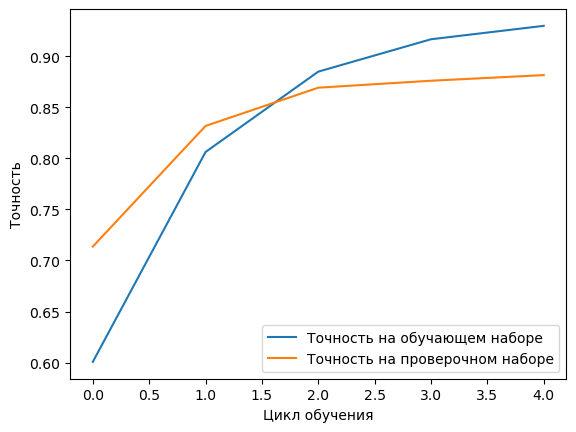

In [93]:
test_val_graph(model.history, 'accuracy', 'val_accuracy')

In [ ]:
#del model
#gc.collect()

#### 07. Оценка эффективности модели на тестовом наборе

In [ ]:
#model = load_model("model.h5")

In [94]:
model.evaluate(X_test, y_test)

32/32 [==============================] - 5s 134ms/step - loss: 0.1663 - accuracy: 0.9520


[0.16626930236816406, 0.9520000219345093]

#### 08. Создадим функцию для проверки модели на собственных предложениях

In [97]:
def text_checker (text):
    t_cleaned = cleaner (text)
    res = model.predict([t_cleaned])
    print ('Окраска текста - ', labeles.classes_[np.argmax(res)])

In [98]:
text_checker('this idea is absolutely bullshit')

1/1 [==============================] - 1s 641ms/step
Окраска текста -  Negative


In [99]:
text_checker('this idea is absolutely brilliant')

1/1 [==============================] - 0s 63ms/step
Окраска текста -  Positive


In [100]:
text_checker('how could it for god sake be')

1/1 [==============================] - 0s 54ms/step
Окраска текста -  Positive


In [101]:
text_checker("i don't think this is a good idea")

1/1 [==============================] - 0s 46ms/step
Окраска текста -  Negative


In [102]:
text_checker("i think this is a bad idea")

1/1 [==============================] - 0s 48ms/step
Окраска текста -  Negative


In [103]:
text_checker("knock the door from the other side")

1/1 [==============================] - 0s 50ms/step
Окраска текста -  Negative


In [104]:
text_checker("fuck off")

1/1 [==============================] - 0s 46ms/step
Окраска текста -  Negative


In [105]:
text_checker("knock yourself out")

1/1 [==============================] - 0s 62ms/step
Окраска текста -  Negative


In [106]:
text_checker("come out")

1/1 [==============================] - 0s 65ms/step
Окраска текста -  Neutral


In [107]:
text_checker("go on")

1/1 [==============================] - 0s 68ms/step
Окраска текста -  Neutral


In [108]:
text_checker("what ever you say")

1/1 [==============================] - 0s 53ms/step
Окраска текста -  Negative
